In [29]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = 'C:\\Users\\User\\ML\\data\\data-science-bowl-2018'
stage_label = 'stage1'

## Read in the labels

In [5]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
28255,f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d...,"[305879, 13, 306481, 15, 307076, 24, 307673, 3..."
16576,8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177...,"[32154, 5, 32672, 8, 33190, 10, 33709, 11, 342..."
27706,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,"[42399, 4, 42653, 7, 42907, 9, 43163, 9, 43419..."


## Load in all Images

In [31]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[7]
img_type = lambda in_path: in_path.split('\\')[8]
img_group = lambda in_path: in_path.split('\\')[6].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[6].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

                                                    path
0      C:\Users\User\ML\data\data-science-bowl-2018\s...
1      C:\Users\User\ML\data\data-science-bowl-2018\s...
2      C:\Users\User\ML\data\data-science-bowl-2018\s...
3      C:\Users\User\ML\data\data-science-bowl-2018\s...
4      C:\Users\User\ML\data\data-science-bowl-2018\s...
...                                                  ...
30191  C:\Users\User\ML\data\data-science-bowl-2018\s...
30192  C:\Users\User\ML\data\data-science-bowl-2018\s...
30193  C:\Users\User\ML\data\data-science-bowl-2018\s...
30194  C:\Users\User\ML\data\data-science-bowl-2018\s...
30195  C:\Users\User\ML\data\data-science-bowl-2018\s...

[30196 rows x 1 columns]


,path,ImageId,ImageType,TrainingSplit,Stage
19133,C:\Users\User\ML\data\data-science-bowl-2018\s...,a0afead3b4fe393f6a6159de040ecb2e66f8a89090abf0...,masks,train,stage1
12797,C:\Users\User\ML\data\data-science-bowl-2018\s...,62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa7...,masks,train,stage1


## Create Training Data

In [32]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 1s


,Stage,ImageId,masks,images
567,stage1,d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.023529411764705882, 0.023529411764705882,..."


## Show a few images

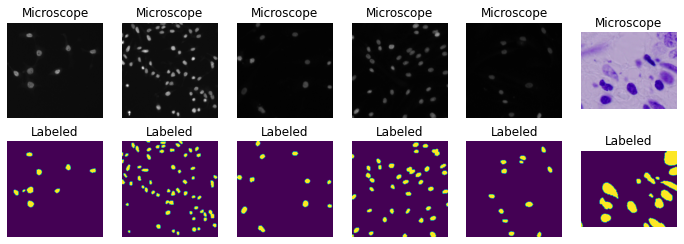

In [33]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

## Look at the intensity distribution

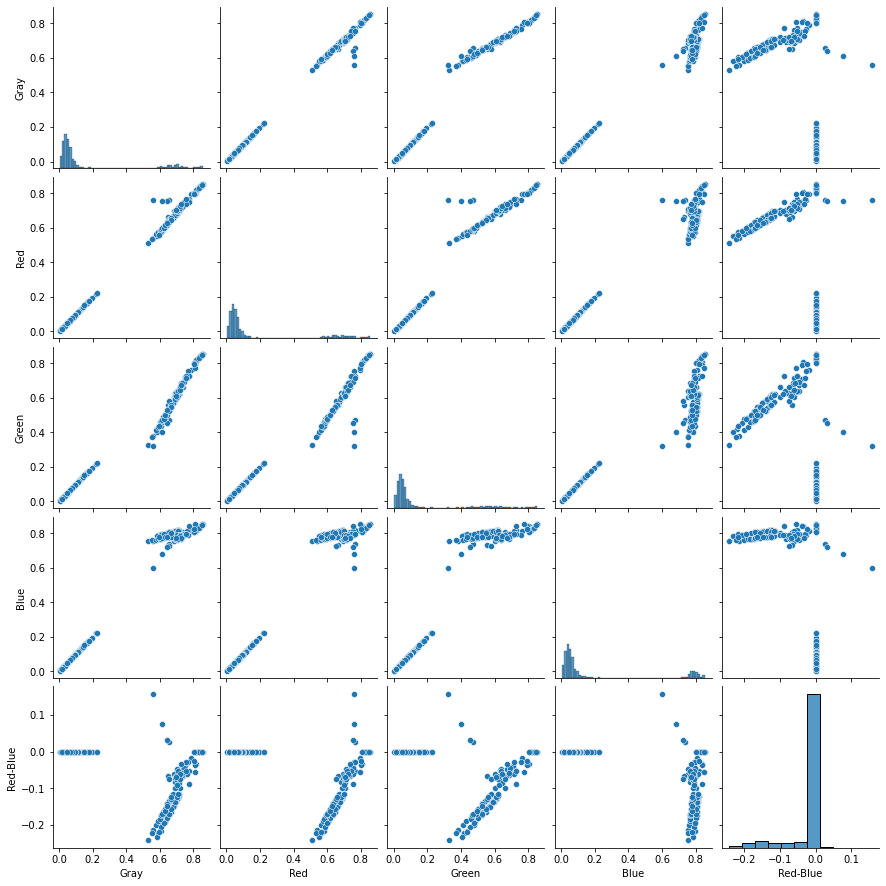

In [34]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

## Check Dimensions

In [35]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

## Making a simple CNN

In [38]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn=Sequential()
simple_cnn.add(BatchNormalization(input_shape=(None,None,IMG_CHANNELS), name='NormalizeInput'))
simple_cnn.add(Conv2D(8,kernel_size=(3,3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)   

## Loss

In [46]:
from keras import backend as K
import tensorflow as tf
smooth = 1.
def dice_coef(y_true,y_pred):
    y_true_f=tf.cast(K.flatten(y_true),tf.float32)
    y_pred_f=tf.cast(K.flatten(y_pred),tf.float32)
    intersection=K.sum(y_true_f * y_pred_f)
    return (2*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true,y_pred)

simple_cnn.compile(optimizer='adam',
                  loss = dice_coef_loss,
                  metrics=[dice_coef,'acc','mse'])

## Simple Training

In [47]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3
670/670 [==============================] - 175s 261ms/step - loss: -0.7257 - dice_coef: 0.7257 - acc: 0.8703 - mse: 0.1246
Epoch 2/3
670/670 [==============================] - 172s 257ms/step - loss: -0.7970 - dice_coef: 0.7970 - acc: 0.8879 - mse: 0.1057
Epoch 3/3
670/670 [==============================] - 173s 258ms/step - loss: -0.8053 - dice_coef: 0.8053 - acc: 0.8909 - mse: 0.1037


## Apply Model to Test

In [48]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 744 ms


,Stage,ImageId,images
55,stage1,d8d4bf68a76e4e4c5f21de7ac613451f7115a04db68615...,"[[[0.050980392156862744, 0.050980392156862744,..."


In [49]:
%%time
test_img_df['masks']=test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x,0))[0,:,:,0])

Wall time: 7.84 s


## Show a few predictions

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


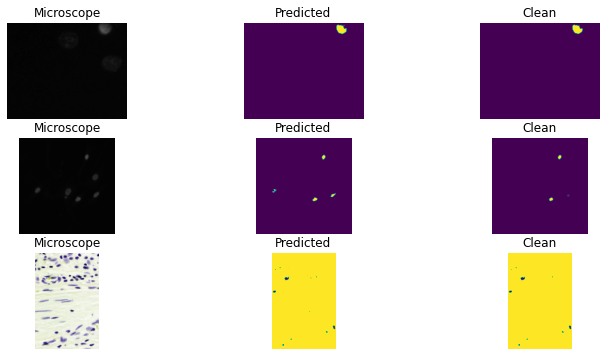

In [50]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

## Check RLE

In [51]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

## Calculate the RLEs for a Train Image

In [52]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

## Take the RLEs from the CSV

In [53]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## Check

In [54]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


## Calculate RLE fro all the masks

In [55]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [56]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1509 regions found for 65 images


,ImageId,EncodedPixels
655,648c8ffa496e1716017906d0bf135debfc93386ae86aa3...,14685 2 14939 6 15195 7 15450 8 15706 9 15962 ...
703,699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...,42 15 303 13 563 13 824 11 1083 11 1341 12 159...
325,432f367a4c5b5674de2e2977744d10289a064e5704b21a...,279 18 799 18 1319 18 1839 18 2359 18 2879 18 ...


In [57]:
out_pred_df[['ImageId','EncodedPixels']].to_csv(os.path.join(dsb_data_dir,'predictions.csv'),index=False)

https://www.kaggle.com/kmader/nuclei-overview-to-submission